# Supervised Learning Project: Finding Donors 

In [2]:
from platform import python_version
print("The Python version I am using: " + python_version())

The Python version I am using: 3.7.3


## 1. Project Description

In this project, we employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publicly available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article [Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature (the number of people the census takers believe that observation represents) and records with missing or ill-formatted entries. Note that the records in this data set were extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)). In other words, these records include individuals above age 16 with an adjusted gross income above $100, who work a positive number of hours per week. Also, the number of people the census takers believe a particular record represents needs to be above 1.

----
## 2. Data Exploration

### Load and Display the Data

Run the code cell below to load necessary Python libraries and the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for dataframes

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the census dataset
data = pd.read_csv("census.csv")

# Display the first five records
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Find the Number of Rows and Explore the Classes 
An investigation of the dataset will determine how many individuals fit into either income group, and will tell us about the percentage of these individuals making more than \$50,000. In the cell below, we compute the following:
- The total number of records, `'n_records'`.
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [4]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income']=='>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income']=='<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = 100*n_greater_50k/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


The above results show that we have an imbalance of classes as only 24.78% of individuals in the data set make more than $50K. This indicates that the accuracy is not a good evaluation metric for the models we will apply to this problem.

### Feature Set Exploration

The following features are available in the data set:

* **age**: numeric. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: numeric. (Note that this feature represents the "education" feature described above as numeric values.) 
* **marital-status**: Married-civ-spouse (married to a spouse not in armed forces), Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse (married to a spouse in armed forces). 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [5]:
# Explore the data types and the number of non-null observations in the columns of the dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


We have 4 float, 1 integer and 9 object type features in our data set. 

In [6]:
# Explore the basic statistical characteristics of all features:
data.describe(include=['object','int','float'])

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,45222.000000,45222,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,34014
mean,38.547941,NaN,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


## 3. Data Visualization and Feature Engineering

### "education-num" and "education_level"

In [7]:
# Compare the value counts of education-num and education_level
edu_num=pd.DataFrame(data['education-num'].value_counts())
edu_num.reset_index(inplace=True)
edu_level=pd.DataFrame(data['education_level'].value_counts())
edu_level.reset_index(inplace=True)
pd.concat([edu_num, edu_level], axis=1, sort=False)

,index,education-num,index,education_level
0,9.0,14783,HS-grad,14783
1,10.0,9899,Some-college,9899
2,13.0,7570,Bachelors,7570
3,14.0,2514,Masters,2514
4,11.0,1959,Assoc-voc,1959
5,7.0,1619,11th,1619
6,12.0,1507,Assoc-acdm,1507
7,6.0,1223,10th,1223
8,4.0,823,7th-8th,823
9,15.0,785,Prof-school,785


As can be seen in the above dataframe, `education-num` feature is only the numeric version of the categorical feature `education_level`, and it does not correctly represent the distance between different levels of education. Therefore, it makes sense to remove `education-num` feature and keep the `education_level`.

In [8]:
# Drop education-num volumn from the data
data.drop('education-num', axis=1, inplace=True)

In [9]:
data

,age,workclass,education_level,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Analysis of Numeric Features 

First, we will convert the categorical feature `income` into a binary variable, '0' indicating '<=50K' and '1' indicating '>50K'.

In [10]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

In [11]:
# Define a function to turn the income feature into a binary feature
def to_binary(x):
    if x=='<=50K':
        return 0
    if x=='>50K':
        return 1 

In [12]:
income_binary = income_raw.apply(to_binary)
income_binary.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

In [13]:
# Import libraries for data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
# Ignore deprecation warnings due to some updates in the packages or for version compatibility etc.
import warnings
warnings.filterwarnings("ignore") 

In [14]:
# Identify and draw histograms for numeric features
def analyze_numeric_features(dataset,target):
    # Define the color and font size for the plot below
    base_color = sns.color_palette()[0]
    # Identify numeric features in the data set
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    numeric_column_number=len(numeric_columns) # Number of numeric features
    axis_length=5 # Base axis length for each graph
    total_y_axis_length=axis_length*numeric_column_number
    f, ax = plt.subplots(numeric_column_number,2,figsize=(2.5*axis_length,total_y_axis_length))
    for i, label in enumerate(numeric_columns):
        extra=(dataset[label].max()-dataset[label].min())/14 
        bin_edges=np.arange(dataset[label].min(), np.ceil(dataset[label].max())+extra, extra)
        bin_idxs=pd.cut(dataset[label], bin_edges, include_lowest=True,labels=False).astype(int)
        pts_per_bin=dataset.groupby(bin_idxs).size()
        count_bins=pd.DataFrame(pts_per_bin[bin_idxs],columns=['count'])
        num_var_weights=np.true_divide(target,count_bins['count'])
        sns.distplot(dataset[label], bins=bin_edges, vertical=True, kde=False, hist_kws={'alpha':1}, ax= ax[i][0]) 
        ax[i,0].set_xlabel('Count')
        ax[i,1].hist(x=dataset[label], bins=bin_edges, weights=num_var_weights, orientation='horizontal', color=base_color)
        ax[i,1].set_xlabel('Mean Income (Income=1 if >=50K, 0 otherwise)') 
    f.tight_layout()
    f.show()   
    return                             

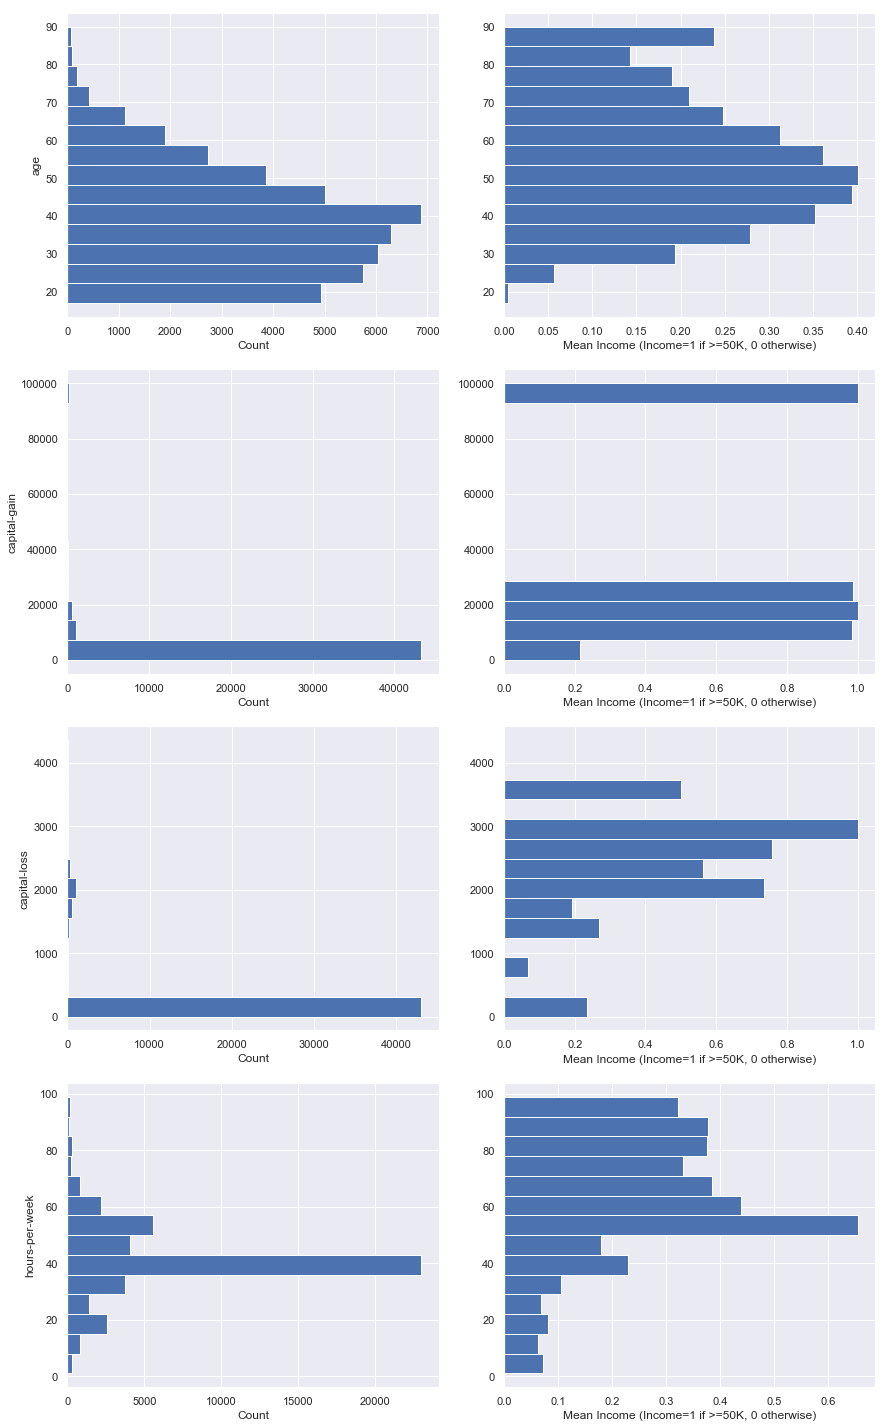

In [15]:
analyze_numeric_features(dataset=features_raw, target=income_binary)

The above graphs show that the `age` and `hours-per-week` features have unimodal distributions with a positive mode and are only slightly skewed while `capital-gain` and `capital-loss` features seem to be concentrated around zero and highly right-skewed. Therefore, `capital-gain` and `capital-loss` will go through logarithmic transformation in the next section, *Preparing the Data*. There is a non-linear relationship between numeric features and the target variable, which makes it more likely for an ensemble method to explain these relations better rather than 

In [16]:
# Draw a heatmap of correlations between all numeric features
def correlation_matrix(dataset):
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    sns.heatmap(dataset[numeric_columns].corr(),cmap='viridis_r',annot=True)

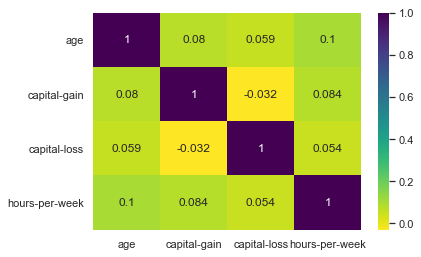

In [17]:
correlation_matrix(features_raw)

The numeric features do not seem to be highly correlated with each other. However, the Pearson correlation only captures the linear relations between the variables. To see the possible non-linear relations between the numeric features we need to draw scatterplots.

In [18]:
def numeric_scatterplots(dataset):
    from itertools import combinations
    base_color = sns.color_palette()[0]
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    numeric_column_number=len(numeric_columns) # Number of numeric features
    axis_length=5 # Base axis length for each graph
    total_y_axis_length=axis_length*len(list(combinations(numeric_columns,2)))
    f, ax = plt.subplots(len(list(combinations(numeric_columns,2))),1,figsize=(1.5*axis_length,total_y_axis_length))
    for i, (x,y) in enumerate(list(combinations(numeric_columns,2))):
        sns.regplot(dataset[x],dataset[y], color=base_color, scatter_kws={'alpha':0.1}, ax=ax[i])   

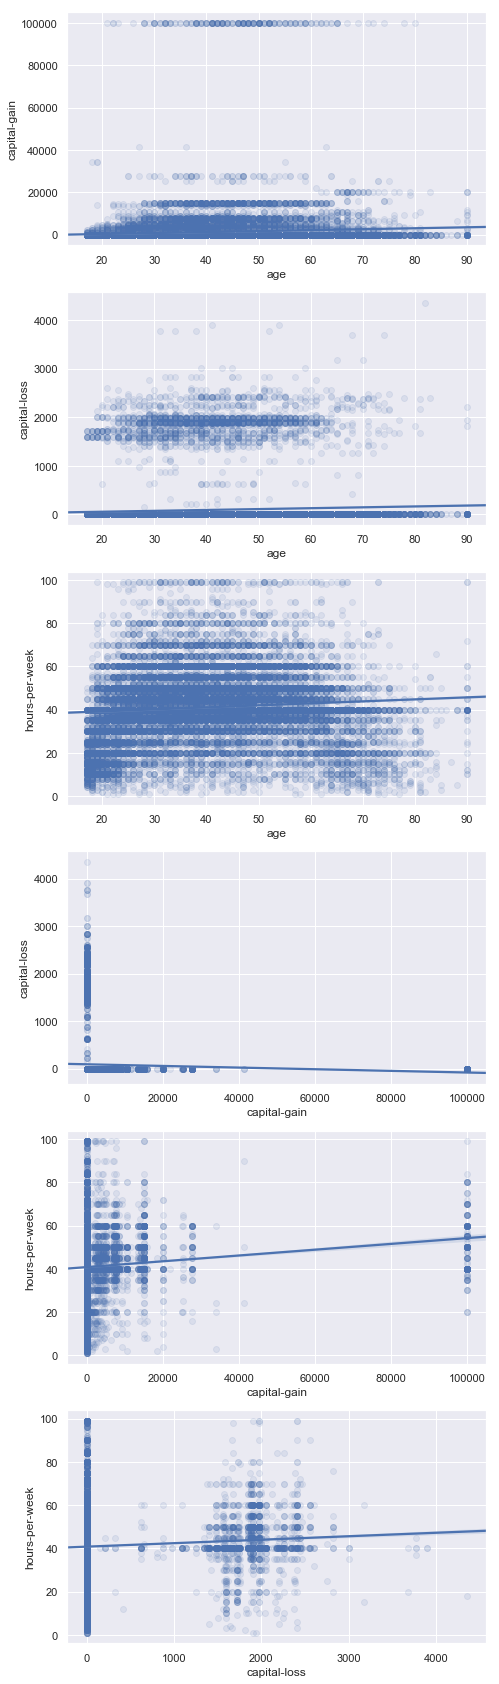

In [19]:
numeric_scatterplots(features_raw)

Capital gain seems to be more or less equally distributed across different ages. Positive capital loss seems to be concentrated between ages 25 and 60. Most people above age 20 work more than 40 hours a week. The graph between capital gain and capital loss reveals the actual non-linear relation between these two features: Only if the capital gain is zero, there can be a positive capital loss and vice versa. It is surprising to see that there is only a slight positive relationship between work-hours per week and capital gain, and there is a slight positive relationship between work-hours per week and capital loss. This might be because people of working age tend to invest their money into housing, etc. and potentially get into debt bacause of it.

### Analysis of Categorical Features

In [20]:
# Write a function to build bar charts for all categorical variables as well as an adapted barcharts showing how the mean income changes for each label of the categorical variables
def analyze_categorical_features(dataset,target):
    # Define the color for the plot
    base_color = sns.color_palette()[0]
    # Identify categorical features in the data set
    cat_columns=dataset.select_dtypes(include=['object']).columns.values.tolist()
    cat_column_number=len(cat_columns) # Number of numeric features
    axis_length=5 # Base axis length for each graph
    total_y_axis_length=axis_length*cat_column_number
    f, ax = plt.subplots(cat_column_number,2,figsize=(2.5*axis_length,total_y_axis_length))
    for i, label in enumerate(cat_columns):
        # Get the frequency order from high to low frequency for nominal variables 
        order= dataset[label].value_counts().index
        sns.countplot(data=dataset, y=label, order=order, color=base_color, ax=ax[i][0])
        sns.barplot(x=target, y=dataset[label], order=order, color=base_color, ax=ax[i][1])
        ax[i,1].set_xlabel('Mean Income (Income=1 if >=50K, 0 otherwise)')
    # Change the absolute frequency bar charts to relative frequency
    n_points=data.shape[0]
    j=0
    for i in range(len(cat_columns)):   
        xlimit=ax[i,j].get_xlim()[1]
        limit=xlimit/n_points

        # generate tick mark locations and names
        tick_props = np.arange(0, limit+0.3, 0.2)
        tick_names = ['{:.1f}'.format(v) for v in tick_props]
        ax[i,j].set_xticks(tick_props*n_points)
        ax[i,j].set_xticklabels(tick_names)
        ax[i,j].set_xlabel('Frequency')
        
        # add annotations
        ax[i,j].get_ylabel()
        cat_counts = dataset[ax[i,j].get_ylabel()].value_counts()
        max_count = dataset[ax[i,j].get_ylabel()].value_counts().max()
        locs= ax[i,j].get_yticks() # get the current tick locations and labels
        labels=ax[i,j].get_yticklabels()
        
        # loop through each pair of locations and labels
        for loc, label in zip(locs, labels):
            # get the text property for the label to get the correct count
            count = cat_counts[label.get_text()]
            pct_string = '{:0.1f}%'.format(100*count/n_points)
            # print the annotation just below the top of the bar
            ax[i,j].text(count+(limit+0.25)*n_points*0.1, loc, pct_string, ha = 'center', color = 'black')

    f.tight_layout()
    f.show() 
    return

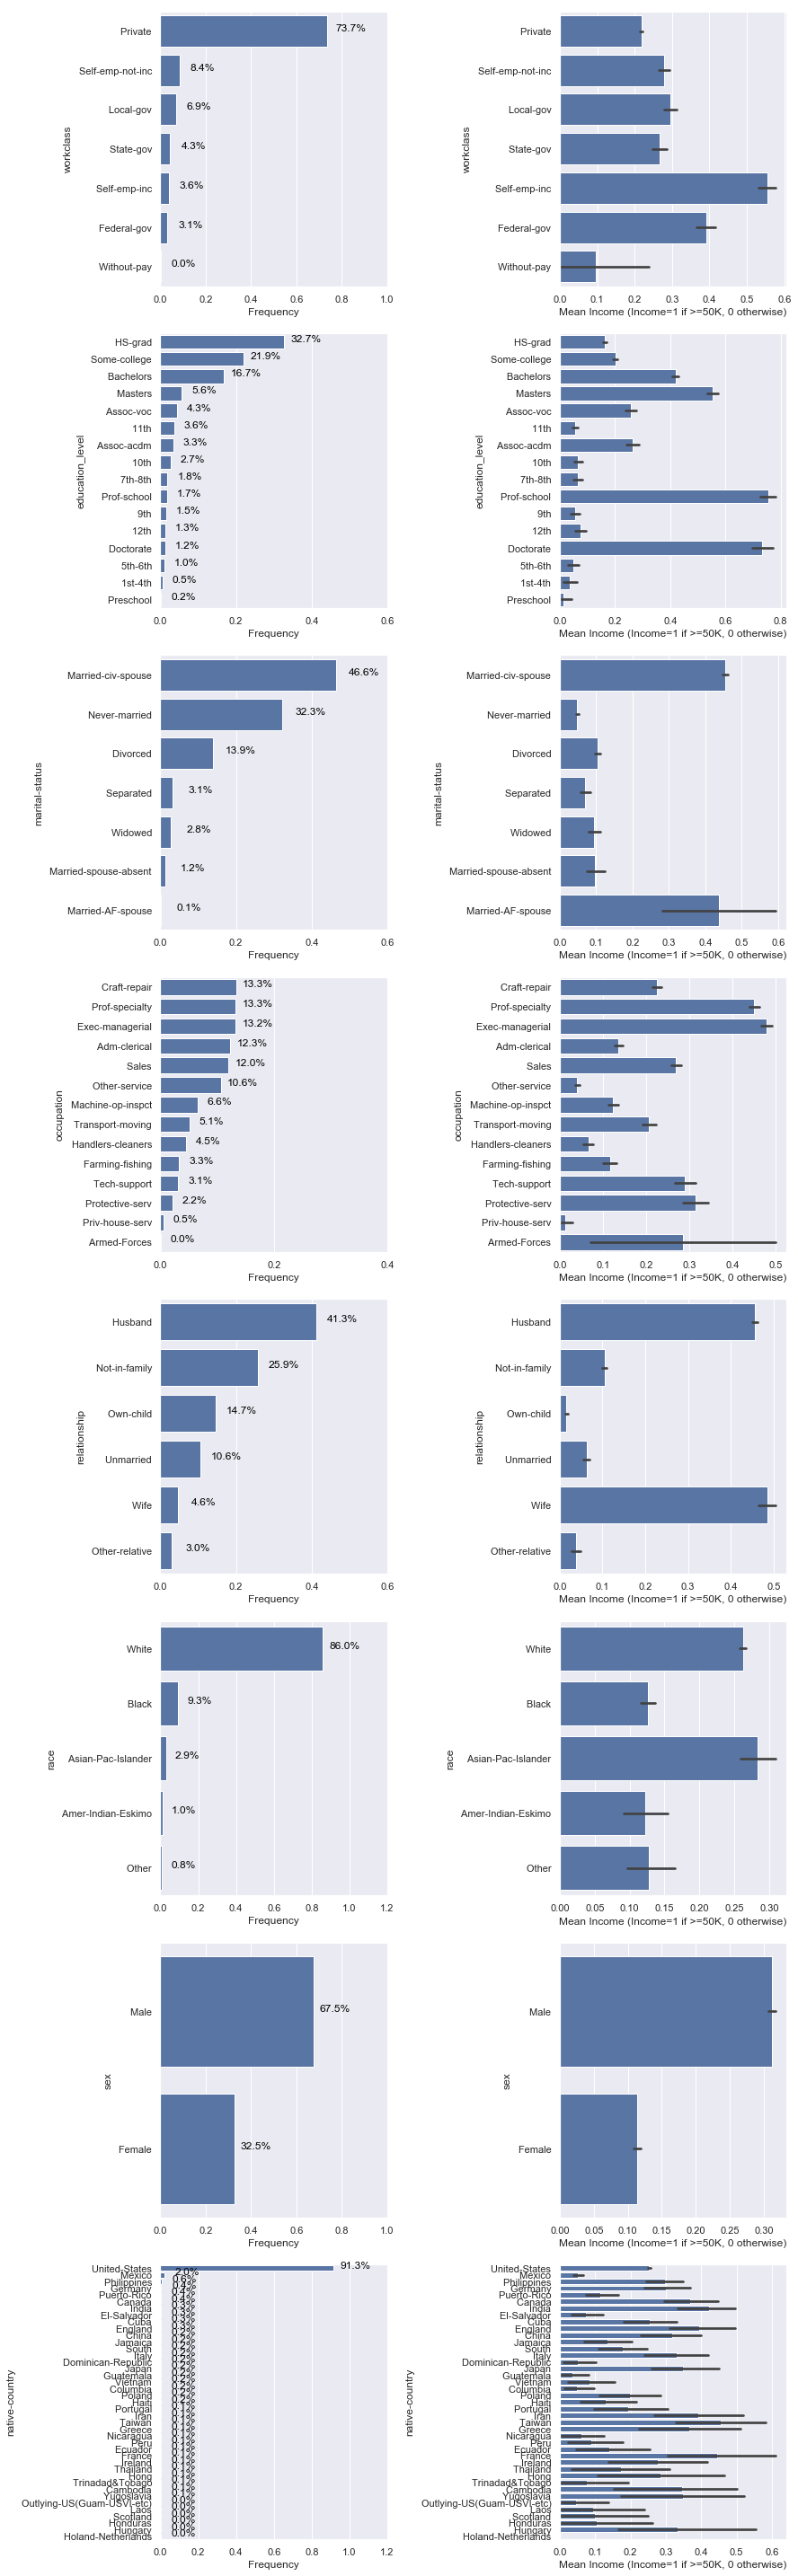

In [21]:
analyze_categorical_features(dataset=features_raw,target=income_binary)

The above charts show that for some labels of categorical features there are too few samples so we will regroup some of these labels with similar mean incomes below:

In [22]:
# Build a data frame which includes the binary income feature and the native-country feature in the data set
country_income=pd.concat([income_binary, features_raw['native-country']], axis=1, join_axes=[income_binary.index])
country_income.head()

,income,native-country
0,0,United-States
1,0,United-States
2,0,United-States
3,0,United-States
4,0,Cuba


In [23]:
# Set the parameters for the bar chart which will show the native countries of the survey respondents sorted by mean income
base_color = sns.color_palette()[0]
group_means=country_income.groupby(['native-country']).mean()
order=group_means.sort_values(['income'],ascending=False).index

Text(0.5, 0, 'Mean Income (Income=1 if >=50K, 0 otherwise)')

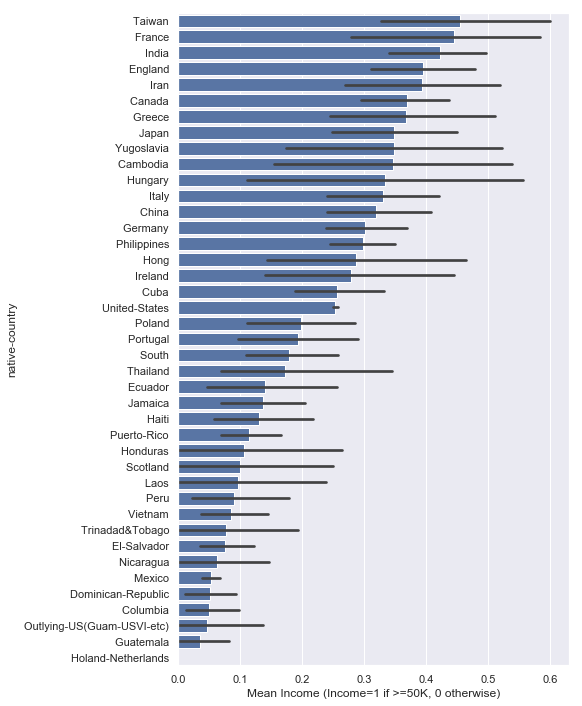

In [24]:
# Draw the bar chart
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(7)
ax=sns.barplot(x=country_income['income'], y=country_income['native-country'], order=order, color=base_color)
ax.set_xlabel('Mean Income (Income=1 if >=50K, 0 otherwise)')

In [38]:
# Aggregate some of the labels in the native-country feature into different socio-economic or geographic regions
features_raw['native-country'][features_raw['native-country'].str.contains("Cambodia")] = "SE-Asia"
features_raw['native-country'][features_raw['native-country'].str.contains("Canada")] = "British-Commonwealth"    
features_raw['native-country'][features_raw['native-country'].str.contains("China")] = "China & Neigh."       
features_raw['native-country'][features_raw['native-country'].str.contains("Columbia")] = "South-America"    
features_raw['native-country'][features_raw['native-country'].str.contains("Cuba")] = "Cuba"        
features_raw['native-country'][features_raw['native-country'].str.contains("Dominican-Republic")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Ecuador")] = "South-America"     
features_raw['native-country'][features_raw['native-country'].str.contains("El-Salvador")] = "South-America" 
features_raw['native-country'][features_raw['native-country'].str.contains("England")] = "British-Commonwealth"
features_raw['native-country'][features_raw['native-country'].str.contains("France")] = "Euro_1"
features_raw['native-country'][features_raw['native-country'].str.contains("Germany")] = "Euro_1"
features_raw['native-country'][features_raw['native-country'].str.contains("Greece")] = "Euro_2"
features_raw['native-country'][features_raw['native-country'].str.contains("Guatemala")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Haiti")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Holand-Netherlands")] = "Euro_1"
features_raw['native-country'][features_raw['native-country'].str.contains("Honduras")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Hong")] = "China & Neigh."
features_raw['native-country'][features_raw['native-country'].str.contains("Hungary")] = "Euro_2"
features_raw['native-country'][features_raw['native-country'].str.contains("India")] = "India"
features_raw['native-country'][features_raw['native-country'].str.contains("Iran")] = "Iran"
features_raw['native-country'][features_raw['native-country'].str.contains("Ireland")] = "British-Commonwealth"
features_raw['native-country'][features_raw['native-country'].str.contains("Italy")] = "Euro_1"
features_raw['native-country'][features_raw['native-country'].str.contains("Jamaica")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Japan")] = "Japan"
features_raw['native-country'][features_raw['native-country'].str.contains("Laos")] = "SE-Asia"
features_raw['native-country'][features_raw['native-country'].str.contains("Mexico")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Nicaragua")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Outlying-US(Guam-USVI-etc)", regex=True)] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Peru")] = "South-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Philippines")] = "SE-Asia"
features_raw['native-country'][features_raw['native-country'].str.contains("Poland")] = "Euro_2"
features_raw['native-country'][features_raw['native-country'].str.contains("Portugal")] = "Euro_2"
features_raw['native-country'][features_raw['native-country'].str.contains("Puerto-Rico")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("Scotland")] = "British-Commonwealth"
features_raw['native-country'][features_raw['native-country'].str.contains("South")] = "Euro_2"
features_raw['native-country'][features_raw['native-country'].str.contains("Taiwan")] = "China & Neigh."
features_raw['native-country'][features_raw['native-country'].str.contains("Thailand")] = "SE-Asia"
features_raw['native-country'][features_raw['native-country'].str.contains("Trinadad&Tobago")] = "Latin-America"
features_raw['native-country'][features_raw['native-country'].str.contains("United-States")] = "United-States"
features_raw['native-country'][features_raw['native-country'].str.contains("Vietnam")] = "SE-Asia"
features_raw['native-country'][features_raw['native-country'].str.contains("Yugoslavia")] = "Euro_2"

In [31]:
# Regroup race feature
features_raw['race'][features_raw['race'].str.contains("Amer-Indian-Eskimo|Other")] = "Other"

In [32]:
# Regroup occupation feature
features_raw['occupation'][features_raw['occupation'].str.contains("Armed-Forces|Protective-serv")] = "Protective-serv"
features_raw['occupation'][features_raw['occupation'].str.contains("Priv-house-serv|Other-service")] = "Other-service"

In [33]:
# Regroup marital-status feature
features_raw['marital-status'][features_raw['marital-status'].str.contains("Married-AF-spouse")] = "Married"
features_raw['marital-status'][features_raw['marital-status'].str.contains("Married-civ-spouse")] = "Married"
features_raw['marital-status'][features_raw['marital-status'].str.contains("Married-spouse-absent")] = "Absent-deceased-spouse"
features_raw['marital-status'][features_raw['marital-status'].str.contains("Widowed")] = "Absent-deceased-spouse"

In [34]:
# Regroup education_level feature
features_raw['education_level'][features_raw['education_level'].str.contains('Preschool|1st-4th|5th-6th', regex=True)] = "Elementary"
features_raw['education_level'][features_raw['education_level'].str.contains('7th-8th|9th|10th|11th|12th', regex=True)] = "Mid-HS-Dropout"
features_raw['education_level'][features_raw['education_level'].str.contains('Prof-school|Doctorate', regex=True)] = "Doctorate"
features_raw['education_level'][features_raw['education_level'].str.contains('Assoc-voc|Assoc-acdm', regex=True)] = "Assoc"

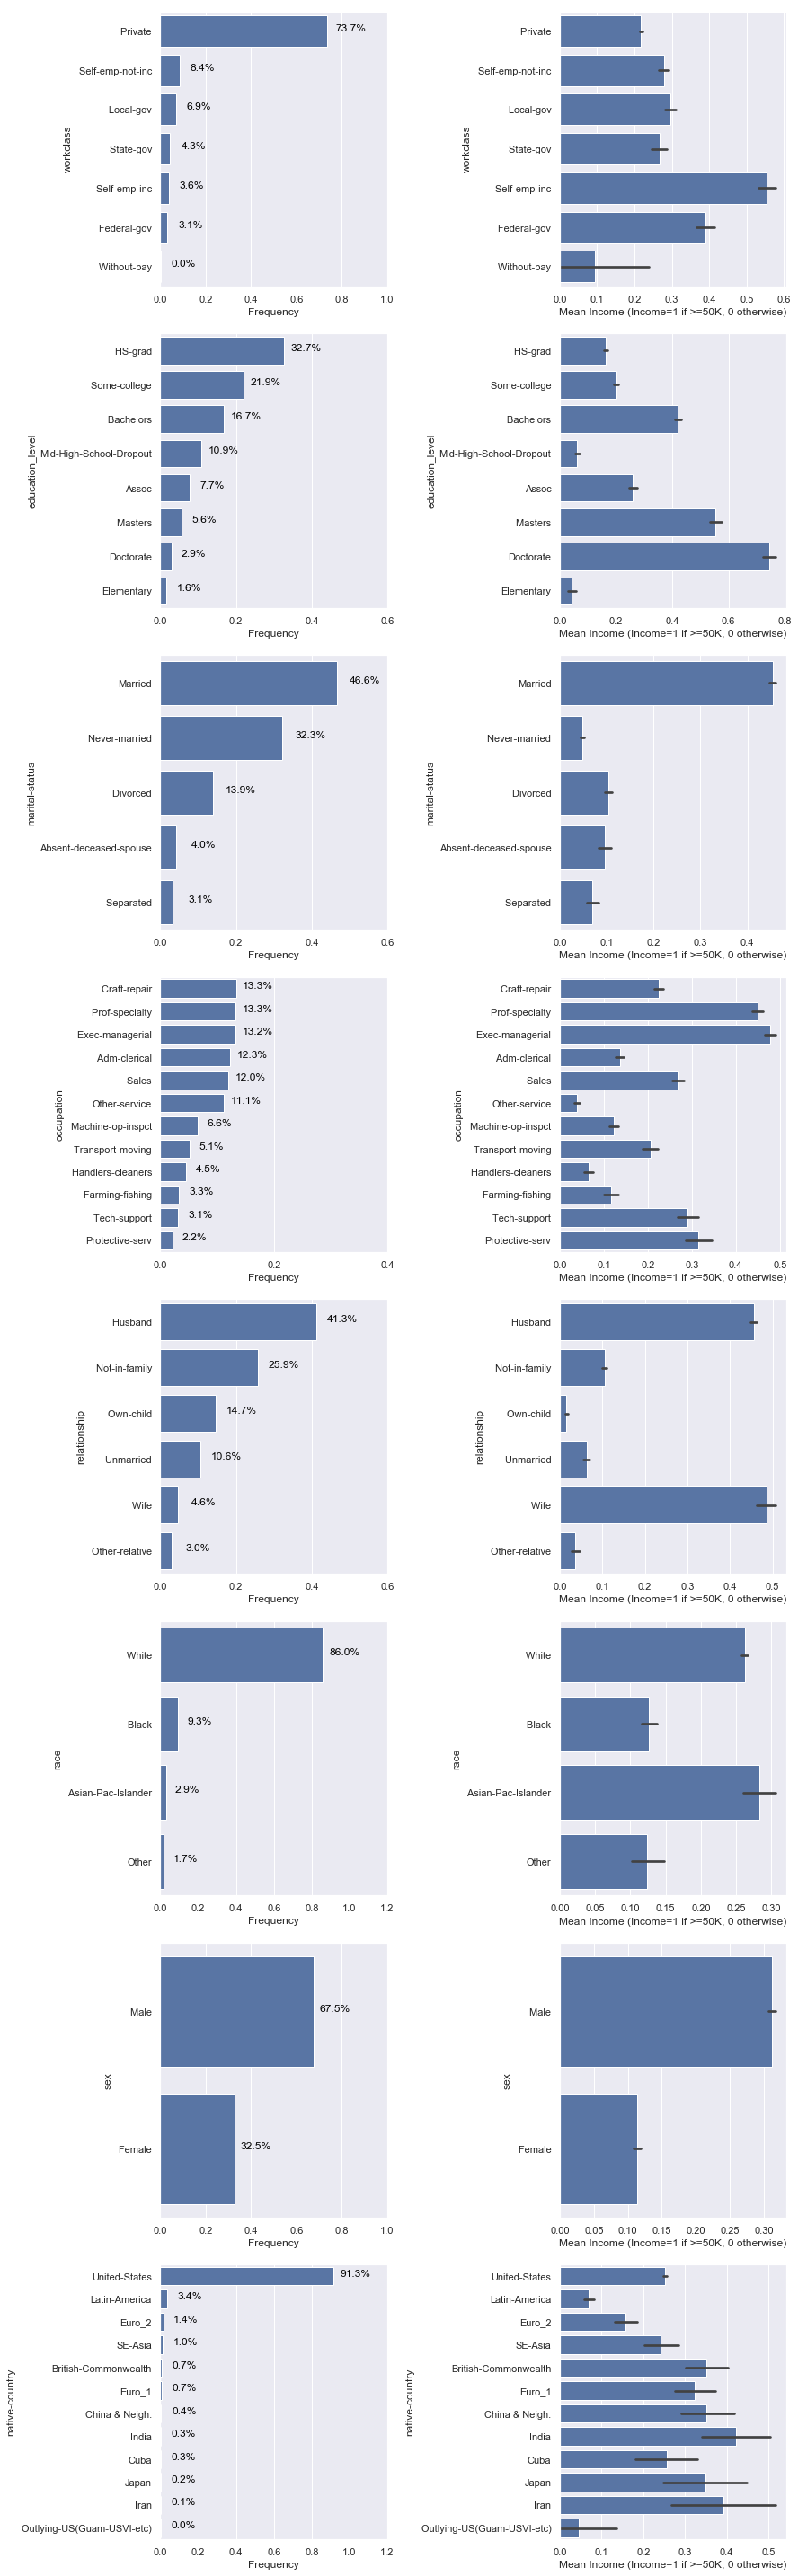

In [39]:
# Show the bar charts for the updated categorical variables
analyze_categorical_features(dataset=features_raw,target=income_binary)

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

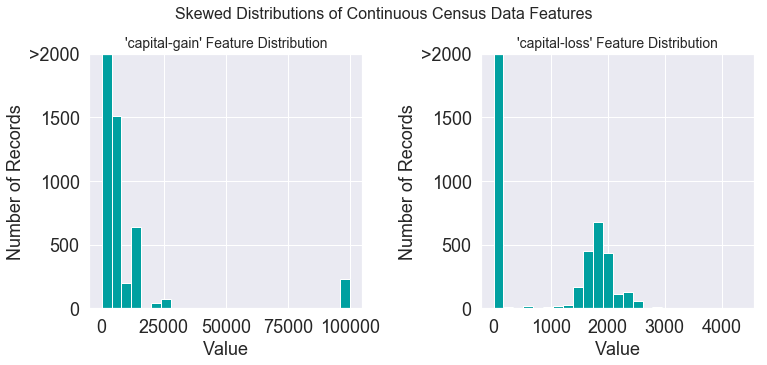

In [134]:
# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

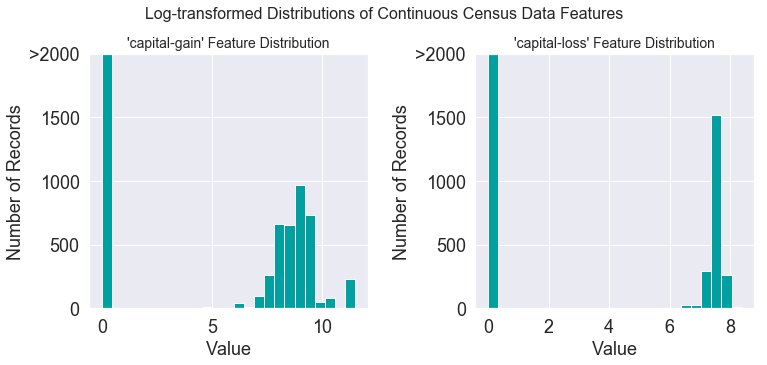

In [135]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [136]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show 5 examples of records with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [137]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = (income_raw=='>50K').astype(int)

# Print the number of features after one-hot encoding
encoded = features_final.columns.values.tolist()
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [138]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performance
If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

Please note that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [139]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore =(1+beta**2)*precision*recall/((beta**2*precision)+recall) 

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application
Three of the supervised learning models appropriate for this problem are listed below that I will test on the census data. For each model chosen:

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

### Answer:

### Model 1: XGBoost 

#### 1.1 Describe one real-world application in industry where the model can be applied.

Given the medical history of a patient, XGBoost classifier can be used to find out about the type of the disease of a patient.


#### 1.2 What are the strengths of the model; when does it perform well?

1- XGBoost model in general has a wide range of application areas and can be used to solve regression, classification, ranking, and user-defined prediction problems.


2- XGBoost model in general has the best combination of prediction performance and processing time compared to other algorithms. 

3- It allows regularization to prevent overfitting and can measure the importance of features.

#### 1.3 What are the weaknesses of the model; when does it perform poorly?

1- XGBoost model has many hyperparameters which need to be tuned using cross-validation to avoid overfitting the data.


#### 1.4 What makes this model a good candidate for the problem, given what you know about the data?

XGBoost algorithm can be used as a binary classification algorithm as in our problem and with careful tuning, can outperform other algorithms in terms of the combination of prediction performance and processing time. 

Reference:

https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

### Model 2:  Random Forest Classifier

#### 1.1 Describe one real-world application in industry where the model can be applied.

In e-commerce settings, random forest algorithm is used to determine whether a customer will like a particular product or not depending on the demographics and purchase history of the customer. 


#### 1.2 What are the strengths of the model; when does it perform well?

1- Unlike regression and logistic regression, tree models can discover hidden patterns which can be revealed by complex interactions in the data.

2- Random Forest Classifier has the ability to automatically determine which features are important.

3- Random Forest Classifier is an ensemble algorithm and improves accuracy by combining results from many models. It is a special type of bagging algorithm: In addition to using bootstrapped samples of training data to build a tree at each step, it also selects a random sample of features, each time it splits a tree.

4- Random Forest is more robust to overfitting compared to XGBoost.

#### 1.3 What are the weaknesses of the model; when does it perform poorly?

1- A large number of trees can make the algorithm to slow down and become ineffective for real-time predictions.

2- This algrorithm is generally fast to train but slow to create predictions.

#### 1.4 What makes this model a good candidate for the problem, given what you know about the data?

Random Forest is another ensemble method which can be used as a binary classification algorithm. Our data also does not have too many features. In cases where there are too many features and the random forest chooses a small number of features in each split, random forest algorithm might perform poorly, which is not the case for this particular data set. Also, given its robustness to overfitting compared to XGBoost, it is an ensemble method which can potentially outperform XGBoost.

Reference: 

https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

### Model 3: Logistic Regression Classifier

#### 1.1 Describe one real-world application in industry where the model can be applied.

Logistic regression can be used to calculate whether a customer will default or not given her loan application data.

#### 1.2 What are the strengths of the model; when does it perform well?

1-Logistic regression performs well if the decision boundary in the problem is close to linear and there is a single decision boundary (binary classification).

#### 1.3 What are the weaknesses of the model; when does it perform poorly?

1- The logistic regression assumes a linear decision boundary so cannot represent complex interactions in the data.

2- The logistic regression performs poorly when multiple decision boundaries are needed for multi-class classification problems.

#### 1.4 What makes this model a good candidate for the problem, given what you know about the data?

Given that we have a binary classification problem, a simple model like logictic regression with a linear boundary might actually perform well without the need for more complex ensemble methods so it would be a good idea to see how this simpler model performs in comparison to Random Forest and XGBoost given our data. If the classifier does not need to reflect complex relations between the predictor variables, logistic regression might perform almost as well as much more complex ensemble methods. 

Reference:

https://elitedatascience.com/machine-learning-algorithms#classification

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [140]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score 
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    
    
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [153]:
# Import the three supervised learning models from sklearn

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Initialize the three models
clf_A = xgb.XGBClassifier(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = LogisticRegression(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

XGBClassifier trained on 361 samples.
XGBClassifier trained on 3617 samples.
XGBClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


In [146]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score

In [160]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Create plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    
    #Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()    

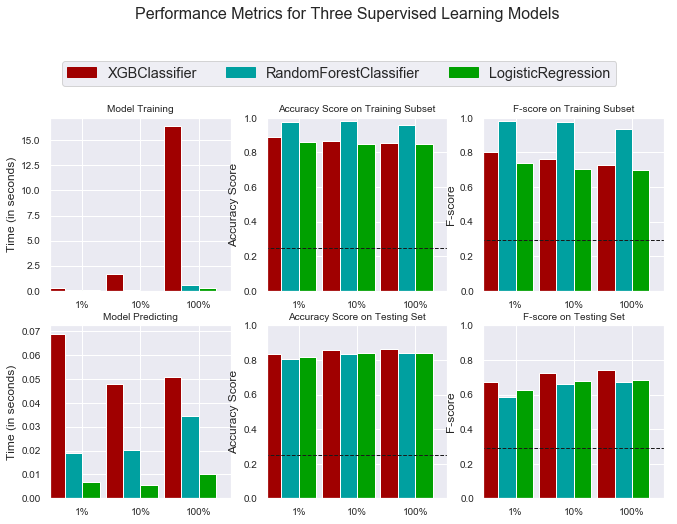

In [152]:
# Run metrics visualization for the three supervised learning models chosen
# Define the color and font size for the plot below
base_color = sns.color_palette()[0]
matplotlib.rcParams.update({'font.size': 12})
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
evaluate(results, accuracy, fscore)

In [12]:
print(results)

{'XGBClassifier': {0: {'train_time': 0.19962000846862793, 'pred_time': 0.06516003608703613, 'acc_train': 0.8866666666666667, 'acc_test': 0.835599778883361, 'f_train': 0.8035714285714285, 'f_test': 0.6729111596368234}, 1: {'train_time': 1.669849157333374, 'pred_time': 0.06404399871826172, 'acc_train': 0.8666666666666667, 'acc_test': 0.8568269762299613, 'f_train': 0.7617187499999999, 'f_test': 0.7254002015000561}, 2: {'train_time': 16.004209756851196, 'pred_time': 0.054312944412231445, 'acc_train': 0.8533333333333334, 'acc_test': 0.8632393587617468, 'f_train': 0.7291666666666667, 'f_test': 0.7435430651951304}}, 'RandomForestClassifier': {0: {'train_time': 0.026723146438598633, 'pred_time': 0.021279096603393555, 'acc_train': 0.9766666666666667, 'acc_test': 0.802653399668325, 'f_train': 0.9789156626506026, 'f_test': 0.5869035179380007}, 1: {'train_time': 0.048603057861328125, 'pred_time': 0.0245668888092041, 'acc_train': 0.98, 'acc_test': 0.831951354339414, 'f_train': 0.9738372093023256, '

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

__Answer:__

Given the graphs and the results above, the XGBClassifier, the wrapper of the XGBoost model in Python, performs the best in terms of the F score on the testing data when 100% if the training data is used. In this case, f_test is 0.8632393587617468. Although the XGBClassifier has the highest prediction and training time, given the small size of the data, the computation is of little concern. Finally, XGBoost model in general can be used for a large set of applications including binary classification models and can handle a mix of categorical and numerical data as in our data here. Finally, XGBClassifier performs better than other classifiers without tuning its many hyperparameters. Tuning the hyperparameters carefully by cross-validation in the next stages can prevent overfitting and improve the performance of the algorithm significantly, Therefore, it is reasonable to proceed with the XGBClassifier.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer:** 

XGBoost (extreme gradient boosting) is an ensemble method which uses several decision tree models to train the data. At each iteration of the algorithm, XGBoost splits the people in the data set into two subgroups depending on, for example, the education levels of individuals and in this way constructs a decision tree model. Then, XGBoost adds decision tree models on top of each other sequentially and fits the new model to the residuals of the previous model to minimize the loss when adding the latest prediction. The errors of the previous model are corrected in this way (using the gradient descent algorithm) by the next model, until the training data is accurately predicted by the final model. XGBoost also has a regularization term in the objective function which prevents the model from overfitting the training data. 

After, we fit the final model, we will use the parameters of the fitted model to make a prediction on the testing data and measure the accuracy of the prediction by using accuracy score and F-score. 

https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [157]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = xgb.XGBClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_depth': [1,2,3], 'learning_rate': [0.1,0.3,1], 'n_estimators':[300, 400, 500]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,cv=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8632
F-score on testing data: 0.7435

Optimized Model
------
Final accuracy score on the testing data: 0.8712
Final F-score on the testing data: 0.7541


In [14]:
# Show the parameters of the optimized model
grid_fit.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}

### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |0.8632             |     0.8705      |
| F-score        |0.7435             |     0.7528      |


**Answer:**

The optimized accuracy of the testing data is 0.8705 and the F-score is 0.7528. These scores are slightly better than the ones in the unoptimized model. The Naive predictor benchmark in Question 1 resulted in an accuracy score of 0.2478 and an F-score of 0.2917. Compared to these scores, the XGB Classifier performs significantly better.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

The occupation is the most significant predictor of direct income. For example, a person with an executive-managerial role is more likely to be paid more than $50K than somebody in an administrative-clerical role. The amount of capital gain might be the second most important feature affecting the income of a person. While significant, capital gain might have less of an effect compared to occupation which usually corresponds to a larger some of money. Third, education might be an important predictor of income. A person with a higher education is more likely to get paid a higher salary. However, there might not be always a linear relationship between education and income. Fourth, sex might be a factor affecting income as women are paid approximately 80% of what man are paid for doing the same job. Finally, age might be an important factor to predict income as people usually get promoted as they earn seniority in their jobs. However, this might not correspond to a large change in the income. Finally, 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

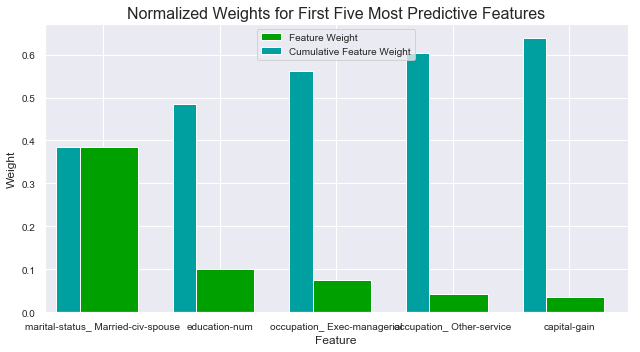

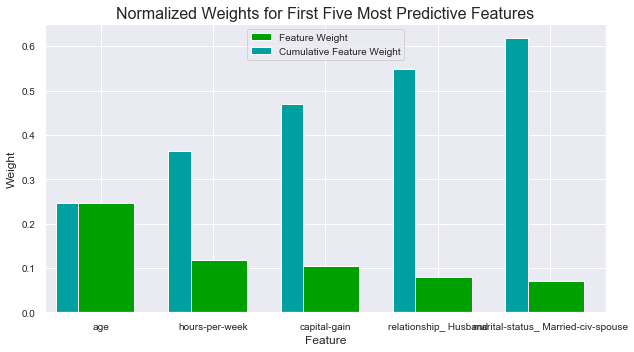

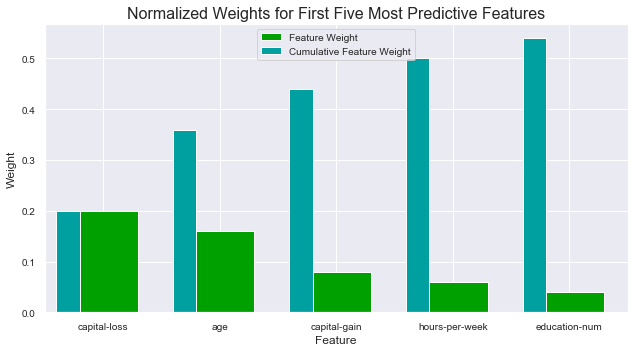

In [158]:
# Import a supervised learning model that has 'feature_importances_'
# Will use three supervised learning models to compare the most important features 
# Already imported xgboost to use the supervised learning algorithm XGBClassifier for feature importance
# Already imported random forest classifier 
# Import adaboost classifier

from sklearn.ensemble import AdaBoostClassifier



# Import functionality for cloning a model
from sklearn.base import clone

# Train the supervised model on the training set using .fit(X_train, y_train)
model1 = (clone(best_clf)).fit(X_train, y_train) # Using the clone of best_clf computed above using xgboost classifier
model2=RandomForestClassifier(random_state=0)
model2.fit(X_train, y_train) 
model3=AdaBoostClassifier(random_state=0)
model3.fit(X_train, y_train) 

# Extract the feature importances using .feature_importances_ 
importances1 = model1.feature_importances_ 
importances2 = model2.feature_importances_ 
importances3 = model3.feature_importances_ 

# Plot
vs.feature_plot(importances1, X_train, y_train)
vs.feature_plot(importances2, X_train, y_train)
vs.feature_plot(importances3, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

The last three features in the graph above are related to occupation and capital gain while I predicted these features as the first two features. Looking at the data more carefully, the income actually refers to the household income. Therefore, the household where both spouses are working is the most likely to have an income more than $50,000. The level of education seems to play a big role in determining the income level which was also one of my predictions. It is still surprising that the education level plays a bigger role than one's occupation and capital gain in determining the income level. This might be because of the significant correlation the education level and starting salary regardless of occupation. 

https://faculty.biu.ac.il/~yahavi1/Projects/CP2010T1_rep.pdf

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [159]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances1)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances1)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8712
F-score on testing data: 0.7541

Final Model trained on reduced data
------
Accuracy on testing data: 0.8513
F-score on testing data: 0.7123


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Using only five most important features instead of the full set of features in the data reduces the accuracy by about 2% from 0.8705 to 0.8510. The F-score drops from 0.7528 to 0.7126, about 4%. If the training time was a factor, it would have been a good idea to use the reduced set of features in the training set as the model trained on reduced data still has a good enough prediction power on the testing data.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.